In [8]:
import os
import numpy as np
import pandas as pd
import pysam
import multiprocessing
import matplotlib.pyplot as plt
from pydeseq2.preprocessing import deseq2_norm
import seaborn as sns
import csv
from os.path import join
from scipy.stats import pearsonr
from sklearn.metrics import precision_score, recall_score
import json
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, auc, average_precision_score
from scipy.io import mmread
import matplotlib.patches as patches

In [9]:
def spearman_count(quant_dir_ont, quant_dir_pacbio):
    
    
    #d = ["H9_directRNA (ONT)", "SQ2_HiFi (PacBio)"]
    d = ["H9_directRNA", "SQ2"]
    data_dict = {
    "H9_directRNA": ("drna", quant_dir_ont),
    "SQ2": ("", quant_dir_pacbio)
    }
    ground_truth = {"H9_directRNA":{}, "SQ2": {}}
    t = {"H9_directRNA":{}, "SQ2": {}}
    
    
    #get the ground truth values
    txp = pd.read_csv(f"{quant_dir_ont}/ground_truth/all_transcript_name.csv", header=None, sep="\t")
    first_parts = [s.split('.')[0] for s in list(txp[0])]
    first_parts_df = pd.DataFrame(first_parts)
    first_parts_df.columns = ["Txp"]
    
    
    for k, (v, quant_dir) in data_dict.items():
        if k == "H9_directRNA":
            ground_truth[k] = pd.read_csv(f"{quant_dir}/ground_truth/{k}_ground_truth.csv", header=None, sep="\t")
            ground_truth[k].columns = ["Txp", "Ground_Truth"]
        elif k == "SQ2":
            ground_truth[k] = pd.read_csv(f"{quant_dir}/ground_truth/{k}_ground_truth.csv", sep="\t")
            ground_truth[k].columns = ["Txp", "Ground_Truth"]
            ground_truth[k]["Txp"] = [s.split('.')[0] for s in list(ground_truth[k]["Txp"])]
    
    for k in t.keys():
        t[k] = pd.merge(first_parts_df, ground_truth[k], left_on="Txp", right_on="Txp", how="left")
        t[k] = t[k].fillna(0)      
    
    
    
    #read in the count files   
    oarfish_align_cov = {k: {} for k in d}
    oarfish_align_nocov = {k: {} for k in d}
    #oarfish_raw_cov = {k: {} for k in d}
    #oarfish_raw_nocov = {k: {} for k in d}
    NanoCount = {k: {} for k in d}
    NanoCount_nofilt = {k: {} for k in d}
    bambu = {k: {} for k in d}
    kallisto = {k: {} for k in d}
    isoquant = {k: {} for k in d}
    espresso = {k: {} for k in d}
    transigner = {k: {} for k in d}
    
    
    for k, (v, quant_dir) in data_dict.items():
        oarfish_align_cov[k] = pd.read_csv(join(quant_dir, 'oarfish_align_quant', k, v, 'out_cov.quant'), sep="\t")
        oarfish_align_cov[k]['tname'] = oarfish_align_cov[k]['tname'].apply(lambda x: x.split('.')[0])
        ###########################################################################################
        oarfish_align_nocov[k] = pd.read_csv(join(quant_dir, 'oarfish_align_quant', k, v, 'out_nocov.quant'), sep="\t")
        oarfish_align_nocov[k]['tname'] = oarfish_align_nocov[k]['tname'].apply(lambda x: x.split('.')[0])
        ##########################################################################################
        #oarfish_raw_cov[k] = pd.read_csv(f"{quant_dir}/oarfish_raw_quant/{k}/{v}/out_cov.quant", sep="\t")
        #oarfish_raw_cov[k]['tname'] = oarfish_raw_cov[k]['tname'].apply(lambda x: x.split('.')[0])
        ############################################################################################
        #oarfish_raw_nocov[k] = pd.read_csv(f"{quant_dir}/oarfish_raw_quant/{k}/{v}/out_nocov.quant", sep="\t")
        #oarfish_raw_nocov[k]['tname'] = oarfish_raw_nocov[k]['tname'].apply(lambda x: x.split('.')[0])
        ##########################################################################################
        NanoCount[k] = pd.read_csv(join(quant_dir, 'NanoCount_quant', k, v, 'isoform_expression_estimates'), sep="\t")
        NanoCount[k].rename(columns={NanoCount[k].columns[2]: "num_reads"}, inplace=True)
        NanoCount[k]['transcript_name'] = NanoCount[k]['transcript_name'].apply(lambda x: x.split('.')[0])
        NanoCount[k] = NanoCount[k].groupby(NanoCount[k]['transcript_name'])['num_reads'].sum().reset_index()
        ###########################################################################################
        NanoCount_nofilt[k] = pd.read_csv(join(quant_dir, 'NanoCount_quant_nofilt', k, v, 'isoform_expression_estimates'), sep="\t")
        NanoCount_nofilt[k].rename(columns={NanoCount_nofilt[k].columns[2]: "num_reads"}, inplace=True)
        NanoCount_nofilt[k]['transcript_name'] = NanoCount_nofilt[k]['transcript_name'].apply(lambda x: x.split('.')[0])
        NanoCount_nofilt[k] = NanoCount_nofilt[k].groupby(NanoCount_nofilt[k]['transcript_name'])['num_reads'].sum().reset_index()
        ###########################################################################################
        bambu[k] = pd.read_csv(join(quant_dir, 'bambu_quant', k, v, 'counts_transcript.txt'), sep="\t")
        bambu[k].rename(columns={bambu[k].columns[2]: "num_reads"}, inplace=True)
        bambu[k]['TXNAME'] = bambu[k]['TXNAME'].apply(lambda x: x.split('.')[0])
        bambu[k] = bambu[k].groupby(bambu[k]['TXNAME'])['num_reads'].sum().reset_index()
        ###########################################################################################
        kallisto[k] = pd.read_csv(join(quant_dir, 'lr-kallisto', k, v, 'bus_quant_tcc.tsv'), sep="\t")
        kallisto[k].rename(columns={kallisto[k].columns[1]: "num_reads"}, inplace=True)
        kallisto[k]["transcript_id"] = kallisto[k]['transcript_id'].apply(lambda x: x.split('.')[0])
        kallisto[k] = kallisto[k].groupby(kallisto[k]['transcript_id'])['num_reads'].sum().reset_index()
        ###########################################################################################
        espresso[k] = pd.read_csv(join(quant_dir, 'espresso_quant', k, v, 'sam_sorted_N2_R0_abundance.esp'), sep="\t")
        espresso[k].rename(columns={espresso[k].columns[3]: "num_reads"}, inplace=True)
        espresso[k]['transcript_ID'] = espresso[k]['transcript_ID'].apply(lambda x: x.split('.')[0])
        espresso[k] = espresso[k].groupby(espresso[k]['transcript_ID'])['num_reads'].sum().reset_index()
        ###########################################################################################
        transigner[k] = pd.read_csv(join(quant_dir, 'transigner_quant', k, v, 'abundances.tsv'), sep="\t", header=None)
        transigner[k].columns = ['Txp', 'abundance', 'num_reads']
        transigner[k].rename(columns={transigner[k].columns[2]: "num_reads"}, inplace=True)
        transigner[k]['Txp'] = transigner[k]['Txp'].apply(lambda x: x.split('.')[0])
        transigner[k] = transigner[k].groupby(transigner[k]['Txp'])['num_reads'].sum().reset_index()
        ###########################################################################################
        isoquant[k] = pd.read_csv(join(quant_dir, 'IsoQuant_quant', k, v, 'OUT/OUT.transcript_counts.tsv'), sep="\t")
        isoquant[k]['#feature_id'] = isoquant[k]['#feature_id'].str.split('.').str[0]
        isoquant[k].rename(columns={isoquant[k].columns[1]: "num_reads"}, inplace=True)
        isoquant[k] = isoquant[k].groupby(isoquant[k]['#feature_id'])['num_reads'].sum().reset_index()
        


    m = {k: {} for k in d}
    
    for v in d:
        #print(v)
        m[v] = pd.merge(oarfish_align_cov[v], t[v], left_on="tname", right_on="Txp", how="left", suffixes=('_align_cov', ''))
        m[v] = m[v].rename(columns={"num_reads" : "oarfish (cov)"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(oarfish_align_nocov[v], m[v], left_on="tname", right_on="Txp", how="right", suffixes=('_align_nocov', ''))
        m[v] = m[v].rename(columns={"num_reads" : "oarfish (nocov)"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        #m[v] = pd.merge(oarfish_raw_cov[v], m[v], left_on="tname", right_on="tname", how="right", suffixes=('_raw_cov', ''))
        #m[v] = m[v].rename(columns={"num_reads" : "oarfish raw (cov)"})
        #print(len(m[v]["tname"]))
        ##--------------------------------------------------------------------------------------------------
        #m[v] = pd.merge(oarfish_raw_nocov[v], m[v], left_on="tname", right_on="tname", how="right", suffixes=('_raw_nocov', ''))
        #m[v] = m[v].rename(columns={"num_reads" : "oarfish raw (nocov)"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(NanoCount[v], m[v], left_on="transcript_name", right_on="Txp", how="right", suffixes=('_NanoCount', ''))
        m[v] = m[v].rename(columns={"num_reads" : "NanoCount"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(NanoCount_nofilt[v], m[v], left_on="transcript_name", right_on="Txp", how="right", suffixes=('_NanoCount_nofilt', ''))
        m[v] = m[v].rename(columns={"num_reads" : "NanoCount (nofilt)"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(bambu[v], m[v], left_on="TXNAME", right_on="Txp", how="right", suffixes=('_bambu', ''))
        m[v] = m[v].rename(columns={"num_reads" : "bambu"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(kallisto[v], m[v], left_on="transcript_id", right_on="Txp", how="right", suffixes=('_kallisto', ''))
        m[v] = m[v].rename(columns={"num_reads" : "lr-kallisto"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(espresso[v], m[v], left_on="transcript_ID", right_on="Txp", how="right", suffixes=('_espresso', ''))
        m[v] = m[v].rename(columns={"num_reads" : "ESPRESSO"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(transigner[v], m[v], left_on="Txp", right_on="Txp", how="right", suffixes=('_transigner', ''))
        m[v] = m[v].rename(columns={"num_reads" : "TranSigner"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(isoquant[v], m[v], left_on="#feature_id", right_on="Txp", how="right", suffixes=('_isoquant', ''))
        m[v] = m[v].rename(columns={"num_reads" : "IsoQuant"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = m[v].fillna(0)
    

    columns_to_compare = ["oarfish (cov)", "oarfish (nocov)", "NanoCount", "NanoCount (nofilt)", "bambu", "lr-kallisto", "TranSigner", "IsoQuant", "ESPRESSO"]
    
    return m
    

In [10]:
method_names = ["oarfish (cov)", "oarfish (nocov)", "NanoCount", "NanoCount (nofilt)", "bambu", "lr-kallisto", "TranSigner", "IsoQuant", "ESPRESSO"]

quant_ont = '/mnt/scratch2/zahra/sim_quant_time/nanosim_quant'
quant_pacbio = '/mnt/scratch2/zahra/sim_quant_time/tksm_quant_new_model'

Quant = {}

Quant = spearman_count(quant_ont, quant_pacbio)

/mnt/scratch2/zahra/tmp/ipykernel_4143528/1597297494.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


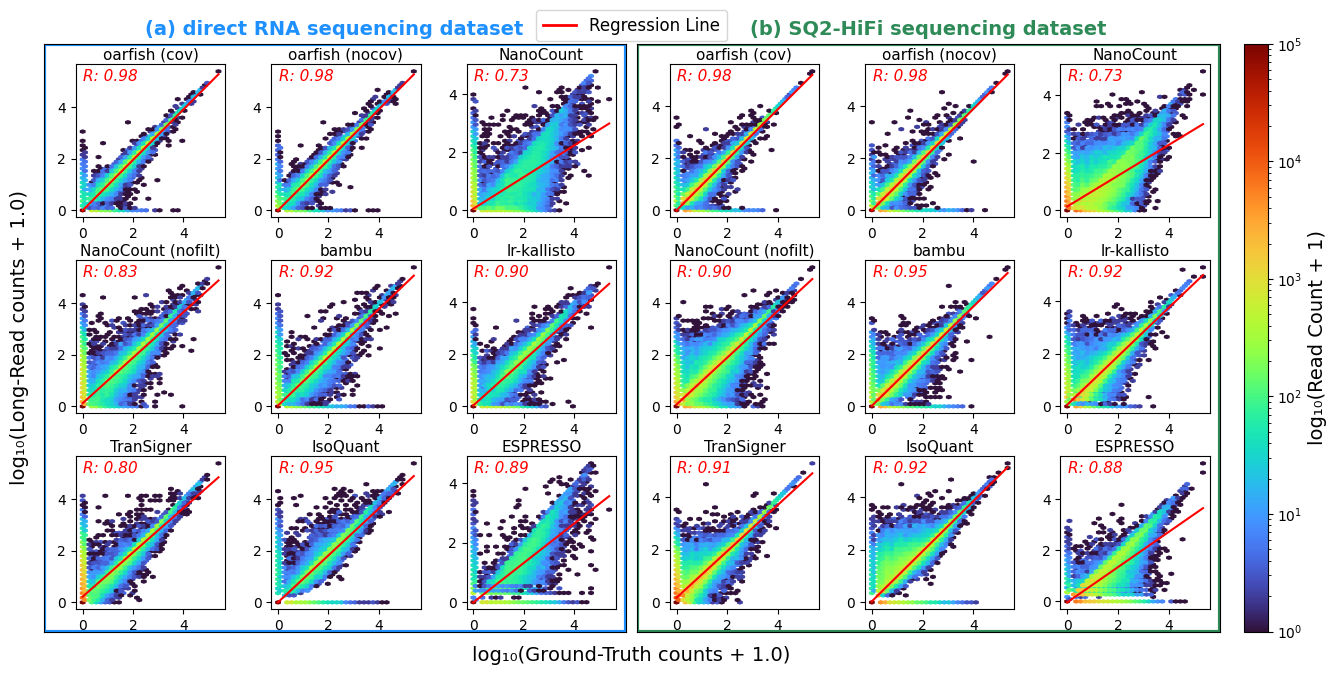

In [11]:
fig_path = '/mnt/scratch2/zahra/oarfish-paper-scripts/analysis_jupyter_notebook/figures/sim_data/drna_hifi/density_plot.jpg'
# Create the figure and define the layout
fig = plt.figure(figsize=(12, 6))  # Width = 12 inches, Height = 8 inches

# Adjust the overall margins of the figure
fig.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.3)  # Overall figure spacing

# Create the outer grid with space between main plots
gs = fig.add_gridspec(1, 2, wspace=0.02)

titles = ['(a) direct RNA sequencing dataset', '(b) SQ2-HiFi sequencing dataset']
datasets = ["H9_directRNA", "SQ2"]
colors = ["lightcyan", "honeydew"]
textcolors = ["dodgerblue", "seagreen"]

# Iterate through main plots and add inner grids with padding
for i, (title, data, color_val, t_color) in enumerate(zip(titles, datasets, colors, textcolors)):
    ax = fig.add_subplot(gs[0, i])
    ax.set_title(title, fontsize=14, fontweight='bold', color=t_color)  # Customize title font
    
    # Define the inner gridspec within each main plot area with increased spacing
    gs_inner = gs[0, i].subgridspec(3, 3, wspace=0.02, hspace=0.0)  # Controls spacing between inner subplots
    
    for j, method_name in enumerate(method_names):
        row = j // 3
        col = j % 3
        sub_ax = fig.add_subplot(gs_inner[row, col])
    
        illumina_value = np.log10(Quant[data]["Ground_Truth"] + 1.0)
        ont_value = np.log10(Quant[data][method_name] + 1.0)
    
        # Create a hexbin plot
        hb = sub_ax.hexbin(illumina_value, ont_value, gridsize=(30, 30), cmap='turbo', bins='log', mincnt=1)
    
        # Calculate Pearson correlation coefficient and p-value
        r_value, p_value = pearsonr(illumina_value, ont_value)
    
        # Fit a linear regression line
        slope, intercept = np.polyfit(illumina_value, ont_value, 1)
    
        # Add the regression line
        x_values = np.linspace(np.min(illumina_value), np.max(illumina_value), 100)
        y_values = slope * x_values + intercept
        sub_ax.plot(x_values, y_values, color='red', label=f'Regression Line')
    
        # Add method name bar at the top of each plot
        text_x = 0.05
        text_y = 0.97
        
        sub_ax.text(
            text_x, text_y, f'R: {r_value:.2f}', ha='left', va='top', transform=sub_ax.transAxes,
            fontsize=11, fontstyle='italic', color='red'
        )
        ## Manually draw an underline just below the text
        #sub_ax.plot(
        #    [text_x, text_x + 0.35], [text_y - 0.11, text_y - 0.11],  # Adjust length and vertical position
        #    transform=sub_ax.transAxes, color='red', lw=1.5
        #)
        sub_ax.text(0.5, 1.06, method_name, ha='center', va='center', transform=sub_ax.transAxes, bbox=dict(facecolor="none", edgecolor='none', boxstyle='round,pad=0.2', alpha=0.5), fontsize=11)
        
        # Display the legend
        #sub_ax.legend(fontsize=10)
        
        # Add an empty boundary around each inner subplot
        sub_ax.set_position([sub_ax.get_position().x0 + 0.027,  # Adjust x position slightly
                             sub_ax.get_position().y0 + 0.037,  # Adjust y position slightly
                             sub_ax.get_position().width * 0.78,  # Adjust width
                             sub_ax.get_position().height * 0.78])  # Adjust height
        
    # Add a rectangle patch to each main subplot
    rect = patches.Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes,  # Offset for padding
        linewidth=3, edgecolor=t_color, facecolor="none"
    )
    ax.add_patch(rect)
    ax.set_xticks([]) 
    ax.set_yticks([])
    
# Create a fake line for the legend (without plotting it directly in the subplots)
red_line = plt.Line2D([], [], color='red', lw=2, label='Regression Line')

# Add the legend above the two main figures
fig.legend(handles=[red_line], loc='upper center', bbox_to_anchor=(0.5, 1.06), fontsize=12, ncol=1)

# Add common colorbar
cb_ax = fig.add_axes([1.01, 0.01, 0.02, 0.98])  # [left, bottom, width, height]
cb = fig.colorbar(hb, cax=cb_ax, cmap="turbo")
cb.set_label('log₁₀(Read Count + 1)', fontsize=14)

# Set common x and y labels for the entire figure, if needed
fig.text(0.5, -0.03, 'log₁₀(Ground-Truth counts + 1.0)', ha='center', va='center', fontsize=14, color='black')
fig.text(-0.01, 0.5, 'log₁₀(Long-Read counts + 1.0)', ha='center', va='center', rotation='vertical', fontsize=14, color='black')

# Adjust layout to make sure everything fits well
plt.tight_layout()
# Save the figure as a JPEG file
directory = os.path.dirname(fig_path)
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig(fig_path, format='jpg', dpi=300, bbox_inches='tight')
plt.show()
